In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import gc

import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import optuna
from optuna.pruners import MedianPruner

import mlflow
import mlflow.pytorch
import dagshub

print("Imports completados")

Imports completados


In [34]:
class Config:
    DIR_BASE = Path("/home2/DSMaster/mgarcia/Tarea 7")
    DIR_DATOS = DIR_BASE / "datos"
    DIR_CELEBA = DIR_DATOS / "celeba"
    IMAGENES_CELEBA = DIR_CELEBA / "img_align_celeba"
    ARCHIVO_ATRIBUTOS = DIR_CELEBA / "list_attr_celeba.txt"
    DIR_MI_ROSTRO = DIR_DATOS / "mi_rostro"
    DIR_MODELOS = DIR_BASE / "modelos"
    DIR_RESULTADOS = DIR_BASE / "resultados"
    DIR_MLRUNS = DIR_BASE / "mlruns"
    
    DIR_MODELOS.mkdir(exist_ok=True)
    DIR_RESULTADOS.mkdir(exist_ok=True)
    DIR_MLRUNS.mkdir(exist_ok=True)
    
    TAMANO_IMG = 128
    NUM_WORKERS = 8
    
    ATRIBUTOS = ['Attractive', 'Male', 'Smiling', 'Wearing_Lipstick', 'Young', 
                 'Eyeglasses', 'Black_Hair', 'Blond_Hair', 'Brown_Hair']
    NUM_ATRIBUTOS = len(ATRIBUTOS)
    
    TRIALS_PREENTRENAMIENTO = 20
    TRIALS_TRANSFER = 30
    TRIALS_FINETUNE = 20
    
    EPOCAS_PREENTRENAMIENTO = 25
    EPOCAS_TRANSFER = 60
    EPOCAS_FINETUNE = 40
    
    EXPERIMENTO = "reconocimiento_facial"
    SEMILLA = 42

torch.manual_seed(Config.SEMILLA)
np.random.seed(Config.SEMILLA)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Config.SEMILLA)

try:
    dagshub.init(repo_owner='404brainnotfound-ai', repo_name='Tarea 7', mlflow=True)
    print(f"DagsHub inicializado")
    print(f"URI de seguimiento: {mlflow.get_tracking_uri()}")
except Exception as e:
    print(f"DagsHub no disponible (sin internet), usando MLflow local: {e}")
    mlflow.set_tracking_uri(f"file:{Config.DIR_MLRUNS}")
    print(f"URI de seguimiento local: {mlflow.get_tracking_uri()}")

mlflow.set_experiment(Config.EXPERIMENTO)

print("Configuracion lista")

Repository Tarea 7 doesn't exist, creating it under current user.

ERROR:dagshub.upload.wrapper:Response (422):
[{"fieldNames":["Name"],"classification":"AlphaDashDotError","message":"AlphaDashDot"}]


DagsHub no disponible (sin internet), usando MLflow local: Repository name is invalid or it already exists.
URI de seguimiento local: file:/home2/DSMaster/mgarcia/Tarea 7/mlruns
Configuracion lista


In [35]:
def obtener_transforms(tamano, aumentar=True):
    if aumentar:
        return transforms.Compose([
            transforms.Resize((tamano, tamano)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    return transforms.Compose([
        transforms.Resize((tamano, tamano)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class DatasetCelebA(Dataset):
    def __init__(self, dir_imagenes, archivo_atributos, atributos, transform=None, limite=None):
        self.dir_imagenes = Path(dir_imagenes)
        self.transform = transform
        self.atributos = atributos
        df = pd.read_csv(archivo_atributos)
        self.datos = df[['image_id'] + atributos].copy()
        for attr in atributos:
            self.datos[attr] = (self.datos[attr] + 1) // 2
        if limite:
            self.datos = self.datos.head(limite)
    
    def __len__(self):
        return len(self.datos)
    
    def __getitem__(self, idx):
        fila = self.datos.iloc[idx]
        ruta = self.dir_imagenes / fila['image_id']
        img = Image.open(ruta).convert('RGB')
        if self.transform:
            img = self.transform(img)
        labels = torch.tensor(fila[self.atributos].values.astype(np.float32))
        return img, labels

class DatasetRostros(Dataset):
    def __init__(self, dir_positivas, dir_negativas, transform=None, num_negativas=200):
        self.transform = transform
        self.muestras = []
        dir_pos = Path(dir_positivas)
        for ext in ['*.jpg', '*.png', '*.jpeg']:
            for ruta in dir_pos.glob(ext):
                self.muestras.append((str(ruta), 1))
        dir_neg = Path(dir_negativas)
        imagenes_neg = list(dir_neg.glob('*.jpg'))[:num_negativas]
        for ruta in imagenes_neg:
            self.muestras.append((str(ruta), 0))
    
    def __len__(self):
        return len(self.muestras)
    
    def __getitem__(self, idx):
        ruta, label = self.muestras[idx]
        img = Image.open(ruta).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.float32)

class SubconjuntoTransformado(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        idx_real = self.indices[idx]
        if hasattr(self.dataset, 'datos'):
            fila = self.dataset.datos.iloc[idx_real]
            ruta = self.dataset.dir_imagenes / fila['image_id']
            img = Image.open(ruta).convert('RGB')
            if self.transform:
                img = self.transform(img)
            labels = torch.tensor(fila[self.dataset.atributos].values.astype(np.float32))
            return img, labels
        else:
            ruta, label = self.dataset.muestras[idx_real]
            img = Image.open(ruta).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, torch.tensor(label, dtype=torch.float32)

print("Datasets listos")

Datasets listos


In [36]:
class ModeloCelebA(nn.Module):
    def __init__(self, num_atributos=9, fc_oculto=512, dropout=0.5):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.caracteristicas = nn.Sequential(*list(resnet.children())[:-1])
        self.clasificador = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, fc_oculto),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fc_oculto, num_atributos))
    
    def forward(self, x):
        return self.clasificador(self.caracteristicas(x))

class ModeloRostros(nn.Module):
    def __init__(self, modelo_base, fc_oculto=256, dropout=0.3):
        super().__init__()
        self.caracteristicas = modelo_base.caracteristicas
        self.clasificador = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, fc_oculto),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(fc_oculto, 1))
        
        for param in self.caracteristicas.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        return self.clasificador(self.caracteristicas(x)).squeeze(1)
    
    def descongelar_capas(self, num_capas=3):
        capas = list(self.caracteristicas.children())
        for capa in capas[-num_capas:]:
            for param in capa.parameters():
                param.requires_grad = True

print("Modelos listos")

Modelos listos


In [37]:
def entrenar_epoca(modelo, loader, criterio, optimizador, dispositivo, multietiqueta=False):
    modelo.train()
    perdida_total = 0.0
    correctos = 0
    total = 0
    for x, y in loader:
        x, y = x.to(dispositivo), y.to(dispositivo)
        optimizador.zero_grad()
        salidas = modelo(x)
        loss = criterio(salidas, y)
        loss.backward()
        optimizador.step()
        perdida_total += loss.item() * x.size(0)
        preds = (torch.sigmoid(salidas) > 0.5).float()
        if multietiqueta:
            correctos += (preds == y).sum().item()
            total += y.numel()
        else:
            correctos += (preds == y).sum().item()
            total += y.size(0)
    return perdida_total / len(loader.dataset), correctos / total

def validar_epoca(modelo, loader, criterio, dispositivo, multietiqueta=False):
    modelo.eval()
    perdida_total = 0.0
    correctos = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(dispositivo), y.to(dispositivo)
            salidas = modelo(x)
            loss = criterio(salidas, y)
            perdida_total += loss.item() * x.size(0)
            preds = (torch.sigmoid(salidas) > 0.5).float()
            if multietiqueta:
                correctos += (preds == y).sum().item()
                total += y.numel()
            else:
                correctos += (preds == y).sum().item()
                total += y.size(0)
    return perdida_total / len(loader.dataset), correctos / total

print("Funciones de entrenamiento listas")

Funciones de entrenamiento listas


In [38]:
print("Cargando dataset CelebA")

dataset_celeba = DatasetCelebA(
    Config.IMAGENES_CELEBA,
    Config.ARCHIVO_ATRIBUTOS,
    Config.ATRIBUTOS,
    transform=None,
    limite=None)

tam_train = int(0.9 * len(dataset_celeba))
tam_val = len(dataset_celeba) - tam_train
indices_train, indices_val = torch.utils.data.random_split(
    range(len(dataset_celeba)), [tam_train, tam_val])

print(f"Train: {len(indices_train)}")
print(f"Val: {len(indices_val)}")

mlflow.log_param("celeba_train_size", len(indices_train))
mlflow.log_param("celeba_val_size", len(indices_val))

Cargando dataset CelebA
Train: 182339
Val: 20260


20260

In [39]:
import gc
torch.cuda.empty_cache()
gc.collect()

# Verificar memoria disponible
print(f"Memoria GPU total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
print(f"Memoria GPU reservada: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
print(f"Memoria GPU asignada: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
print(f"Memoria GPU libre: {(torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9:.2f} GB")

Memoria GPU total: 17.06 GB
Memoria GPU reservada: 0.00 GB
Memoria GPU asignada: 0.00 GB
Memoria GPU libre: 17.06 GB


In [40]:
# Mejores parámetros de optimización (Trial 1)
print("Usando mejores parámetros encontrados en optimización previa:")

best_params = {
    'lr': 1.4e-5,
    'wd': 3.1e-5,
    'dropout': 0.40,
    'fc': 512,
    'bs': 32}

print(f"Learning rate: {best_params['lr']}")
print(f"Weight decay: {best_params['wd']}")
print(f"Dropout: {best_params['dropout']}")
print(f"FC hidden: {best_params['fc']}")
print(f"Batch size: {best_params['bs']}")

Usando mejores parámetros encontrados en optimización previa:
Learning rate: 1.4e-05
Weight decay: 3.1e-05
Dropout: 0.4
FC hidden: 512
Batch size: 32


In [ ]:
# ========================================
# CELDA YA EJECUTADA (5+ horas, 02:00-07:15 AM)
# Trial 1: 92.47% accuracy
# Best params: lr=1.4e-5, wd=3.1e-5, dropout=0.40, fc=512, bs=32
# ========================================

print("Optimizando pre-entrenamiento")
print(f"Trials: {Config.TRIALS_PREENTRENAMIENTO}")

mlflow.end_run()
torch.cuda.empty_cache()
gc.collect()

def objetivo_preentrenamiento(trial):
    with mlflow.start_run(run_name=f"pretrain_trial_{trial.number}", nested=True):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
        wd = trial.suggest_loguniform('wd', 1e-6, 1e-3)
        dropout = trial.suggest_uniform('dropout', 0.3, 0.7)
        fc = trial.suggest_categorical('fc', [256, 512, 1024])
        bs = trial.suggest_categorical('bs', [32, 64, 128])
        
        mlflow.log_params({
            'trial': trial.number,
            'lr': lr,
            'wd': wd,
            'dropout': dropout,
            'fc': fc,
            'bs': bs,
            'fase': 'preentrenamiento',
            'modelo': 'ResNet50'})
        
        transform_train = obtener_transforms(Config.TAMANO_IMG, True)
        transform_val = obtener_transforms(Config.TAMANO_IMG, False)
        
        ds_train = SubconjuntoTransformado(dataset_celeba, indices_train.indices, transform_train)
        ds_val = SubconjuntoTransformado(dataset_celeba, indices_val.indices, transform_val)
        
        loader_train = DataLoader(ds_train, batch_size=bs, shuffle=True, 
                                  num_workers=Config.NUM_WORKERS, pin_memory=True)
        loader_val = DataLoader(ds_val, batch_size=bs, shuffle=False,
                                num_workers=Config.NUM_WORKERS, pin_memory=True)
        
        modelo = ModeloCelebA(num_atributos=Config.NUM_ATRIBUTOS, fc_oculto=fc, dropout=dropout)
        modelo = modelo.to(dispositivo)
        
        criterio = nn.BCEWithLogitsLoss()
        opt = optim.Adam(modelo.parameters(), lr=lr, weight_decay=wd)
        
        mejor_acc = 0.0
        for epoca in range(5):
            loss_train, acc_train = entrenar_epoca(modelo, loader_train, criterio, opt, dispositivo, True)
            loss_val, acc_val = validar_epoca(modelo, loader_val, criterio, dispositivo, True)
            
            mlflow.log_metrics({
                'train_loss': loss_train,
                'train_acc': acc_train,
                'val_loss': loss_val,
                'val_acc': acc_val}, step=epoca)
            
            if acc_val > mejor_acc:
                mejor_acc = acc_val
            
            trial.report(acc_val, epoca)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        mlflow.log_metric('best_val_acc', mejor_acc)
        
        del modelo, opt, loader_train, loader_val, ds_train, ds_val
        torch.cuda.empty_cache()
        gc.collect()
        
        return mejor_acc

with mlflow.start_run(run_name="optimizacion_preentrenamiento"):
    mlflow.log_param('n_trials', Config.TRIALS_PREENTRENAMIENTO)
    mlflow.log_param('fase', 'preentrenamiento')
    
    estudio_pre = optuna.create_study(
        direction='maximize',
        study_name='preentrenamiento',
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=2))
    
    estudio_pre.optimize(objetivo_preentrenamiento, n_trials=Config.TRIALS_PREENTRENAMIENTO)
    
    mlflow.log_metric('best_trial_acc', estudio_pre.best_value)
    mlflow.log_params(estudio_pre.best_params)
    
    print(f"Mejor accuracy: {estudio_pre.best_value:.4f}")
    print(f"Mejores params: {estudio_pre.best_params}")

In [41]:
print("Entrenando modelo pre-entrenado final")

# Cerrar cualquier run activo
mlflow.end_run()

# Definir dispositivo
dispositivo = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {dispositivo}")

bp = best_params

with mlflow.start_run(run_name="preentrenamiento_final"):
    mlflow.log_params(bp)
    mlflow.log_param('fase', 'preentrenamiento_final')
    mlflow.log_param('epocas', Config.EPOCAS_PREENTRENAMIENTO)
    mlflow.log_param('modelo', 'ResNet50')
    
    transform_train = obtener_transforms(Config.TAMANO_IMG, True)
    transform_val = obtener_transforms(Config.TAMANO_IMG, False)
    
    ds_train = SubconjuntoTransformado(dataset_celeba, indices_train.indices, transform_train)
    ds_val = SubconjuntoTransformado(dataset_celeba, indices_val.indices, transform_val)
    
    loader_train = DataLoader(ds_train, batch_size=bp['bs'], shuffle=True,
                              num_workers=Config.NUM_WORKERS, pin_memory=True)
    loader_val = DataLoader(ds_val, batch_size=bp['bs'], shuffle=False,
                            num_workers=Config.NUM_WORKERS, pin_memory=True)
    
    modelo_celeba = ModeloCelebA(num_atributos=Config.NUM_ATRIBUTOS, 
                                  fc_oculto=bp['fc'], dropout=bp['dropout'])
    modelo_celeba = modelo_celeba.to(dispositivo)
    
    criterio = nn.BCEWithLogitsLoss()
    opt = optim.Adam(modelo_celeba.parameters(), lr=bp['lr'], weight_decay=bp['wd'])
    
    mejor_acc = 0.0
    for epoca in range(Config.EPOCAS_PREENTRENAMIENTO):
        loss_train, acc_train = entrenar_epoca(modelo_celeba, loader_train, criterio, opt, dispositivo, True)
        loss_val, acc_val = validar_epoca(modelo_celeba, loader_val, criterio, dispositivo, True)
        
        mlflow.log_metrics({
            'train_loss': loss_train,
            'train_acc': acc_train,
            'val_loss': loss_val,
            'val_acc': acc_val}, step=epoca)
        
        if acc_val > mejor_acc:
            mejor_acc = acc_val
            torch.save(modelo_celeba.state_dict(), Config.DIR_MODELOS / "celeba_mejor.pth")
        
        print(f"Epoca {epoca+1}/{Config.EPOCAS_PREENTRENAMIENTO} - "
              f"Train Loss: {loss_train:.4f} Acc: {acc_train:.4f} - "
              f"Val Loss: {loss_val:.4f} Acc: {acc_val:.4f}")
    
    mlflow.log_metric('best_acc', mejor_acc)
    torch.save(modelo_celeba.state_dict(), Config.DIR_MODELOS / "celeba_final.pth")
    mlflow.pytorch.log_model(modelo_celeba, "modelo_celeba")
    mlflow.log_artifact(str(Config.DIR_MODELOS / "celeba_mejor.pth"))
    
    print(f"Mejor accuracy: {mejor_acc:.4f}")

print("Pre-entrenamiento final completado")

Entrenando modelo pre-entrenado final
Usando dispositivo: cuda:0


/home2/DSMaster/mgarcia/miniconda3/envs/rna_pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home2/DSMaster/mgarcia/miniconda3/envs/rna_pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoca 1/25 - Train Loss: 0.2366 Acc: 0.8981 - Val Loss: 0.1874 Acc: 0.9190
Epoca 2/25 - Train Loss: 0.1969 Acc: 0.9151 - Val Loss: 0.1812 Acc: 0.9216
Epoca 3/25 - Train Loss: 0.1872 Acc: 0.9189 - Val Loss: 0.1761 Acc: 0.9233
Epoca 4/25 - Train Loss: 0.1802 Acc: 0.9220 - Val Loss: 0.1738 Acc: 0.9244
Epoca 5/25 - Train Loss: 0.1748 Acc: 0.9242 - Val Loss: 0.1732 Acc: 0.9249
Epoca 6/25 - Train Loss: 0.1706 Acc: 0.9262 - Val Loss: 0.1729 Acc: 0.9246
Epoca 7/25 - Train Loss: 0.1661 Acc: 0.9282 - Val Loss: 0.1755 Acc: 0.9240
Epoca 8/25 - Train Loss: 0.1616 Acc: 0.9301 - Val Loss: 0.1738 Acc: 0.9251
Epoca 9/25 - Train Loss: 0.1574 Acc: 0.9322 - Val Loss: 0.1751 Acc: 0.9243
Epoca 10/25 - Train Loss: 0.1532 Acc: 0.9341 - Val Loss: 0.1775 Acc: 0.9240
Epoca 11/25 - Train Loss: 0.1487 Acc: 0.9360 - Val Loss: 0.1772 Acc: 0.9247
Epoca 12/25 - Train Loss: 0.1441 Acc: 0.9384 - Val Loss: 0.1811 Acc: 0.9234
Epoca 13/25 - Train Loss: 0.1395 Acc: 0.9402 - Val Loss: 0.1847 Acc: 0.9233
Epoca 14/25 - Train L

2025/12/03 14:11:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoca 25/25 - Train Loss: 0.0868 Acc: 0.9648 - Val Loss: 0.2418 Acc: 0.9186


2025/12/03 14:11:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Mejor accuracy: 0.9251
Pre-entrenamiento final completado


In [42]:
print("Cargando dataset rostros")

dataset_rostros = DatasetRostros(
    Config.DIR_MI_ROSTRO,
    Config.IMAGENES_CELEBA,
    transform=None,
    num_negativas=200)

tam_train = int(0.8 * len(dataset_rostros))
tam_val = len(dataset_rostros) - tam_train
indices_train_rostros, indices_val_rostros = torch.utils.data.random_split(
    range(len(dataset_rostros)), [tam_train, tam_val])

print(f"Train: {len(indices_train_rostros)}")
print(f"Val: {len(indices_val_rostros)}")

mlflow.log_param("rostros_train_size", len(indices_train_rostros))
mlflow.log_param("rostros_val_size", len(indices_val_rostros))

Cargando dataset rostros
Train: 196
Val: 49


49

In [44]:
print("Optimizando transfer learning")
print(f"Trials: {Config.TRIALS_TRANSFER}")

# Cerrar cualquier run activo
mlflow.end_run()
torch.cuda.empty_cache()
gc.collect()

modelo_base = modelo_celeba

def objetivo_transfer(trial):
    with mlflow.start_run(run_name=f"transfer_trial_{trial.number}", nested=True):
        lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
        wd = trial.suggest_float('wd', 1e-6, 1e-3, log=True)
        dropout = trial.suggest_float('dropout', 0.2, 0.5)
        fc = trial.suggest_categorical('fc', [128, 256, 512])
        bs = trial.suggest_categorical('bs', [16, 32, 64])
        
        mlflow.log_params({
            'trial': trial.number,
            'lr': lr,
            'wd': wd,
            'dropout': dropout,
            'fc': fc,
            'bs': bs,
            'fase': 'transfer',
            'modelo': 'ResNet50'})
        
        transform_train = obtener_transforms(Config.TAMANO_IMG, True)
        transform_val = obtener_transforms(Config.TAMANO_IMG, False)
        
        ds_train = SubconjuntoTransformado(dataset_rostros, indices_train_rostros.indices, transform_train)
        ds_val = SubconjuntoTransformado(dataset_rostros, indices_val_rostros.indices, transform_val)
        
        loader_train = DataLoader(ds_train, batch_size=bs, shuffle=True,
                                  num_workers=Config.NUM_WORKERS, pin_memory=True)
        loader_val = DataLoader(ds_val, batch_size=bs, shuffle=False,
                                num_workers=Config.NUM_WORKERS, pin_memory=True)
        
        modelo = ModeloRostros(modelo_base, fc_oculto=fc, dropout=dropout)
        modelo = modelo.to(dispositivo)
        
        criterio = nn.BCEWithLogitsLoss()
        params = [p for p in modelo.parameters() if p.requires_grad]
        opt = optim.Adam(params, lr=lr, weight_decay=wd)
        
        mejor_acc = 0.0
        for epoca in range(15):
            loss_train, acc_train = entrenar_epoca(modelo, loader_train, criterio, opt, dispositivo, False)
            loss_val, acc_val = validar_epoca(modelo, loader_val, criterio, dispositivo, False)
            
            mlflow.log_metrics({
                'train_loss': loss_train,
                'train_acc': acc_train,
                'val_loss': loss_val,
                'val_acc': acc_val}, step=epoca)
            
            if acc_val > mejor_acc:
                mejor_acc = acc_val
            
            trial.report(acc_val, epoca)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        mlflow.log_metric('best_val_acc', mejor_acc)
        
        del modelo, opt, loader_train, loader_val, ds_train, ds_val
        torch.cuda.empty_cache()
        gc.collect()
        
        return mejor_acc

with mlflow.start_run(run_name="optimizacion_transfer"):
    mlflow.log_param('n_trials', Config.TRIALS_TRANSFER)
    mlflow.log_param('fase', 'transfer')
    
    estudio_transfer = optuna.create_study(
        direction='maximize',
        study_name='transfer',
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=3))
    
    estudio_transfer.optimize(objetivo_transfer, n_trials=Config.TRIALS_TRANSFER)
    
    mlflow.log_metric('best_trial_acc', estudio_transfer.best_value)
    mlflow.log_params(estudio_transfer.best_params)
    
    print(f"Mejor accuracy: {estudio_transfer.best_value:.4f}")
    print(f"Mejores params: {estudio_transfer.best_params}")

Optimizando transfer learning
Trials: 30


[I 2025-12-03 14:15:14,009] A new study created in memory with name: transfer
[I 2025-12-03 14:15:28,977] Trial 0 finished with value: 0.9387755102040817 and parameters: {'lr': 0.0001598000908303203, 'wd': 0.00013576697680155444, 'dropout': 0.37017326076469004, 'fc': 512, 'bs': 32}. Best is trial 0 with value: 0.9387755102040817.
[I 2025-12-03 14:15:43,921] Trial 1 finished with value: 0.9387755102040817 and parameters: {'lr': 0.0003135503903635205, 'wd': 1.220863387014083e-05, 'dropout': 0.3364808416686884, 'fc': 128, 'bs': 32}. Best is trial 0 with value: 0.9387755102040817.
[I 2025-12-03 14:15:57,815] Trial 2 finished with value: 0.8367346938775511 and parameters: {'lr': 4.160414556544458e-05, 'wd': 8.343504922683396e-06, 'dropout': 0.24485700107846103, 'fc': 128, 'bs': 16}. Best is trial 0 with value: 0.9387755102040817.
[I 2025-12-03 14:16:11,690] Trial 3 finished with value: 0.9387755102040817 and parameters: {'lr': 0.00013168751511376936, 'wd': 0.00014738540955218322, 'dropout':

Mejor accuracy: 1.0000
Mejores params: {'lr': 0.0009416458573134013, 'wd': 0.0008356848835745776, 'dropout': 0.3348864326975483, 'fc': 512, 'bs': 32}


In [45]:
print("Entrenando transfer learning final")

with mlflow.start_run(run_name="transfer_final"):
    bp = estudio_transfer.best_params
    mlflow.log_params(bp)
    mlflow.log_param('fase', 'transfer_final')
    mlflow.log_param('epocas', Config.EPOCAS_TRANSFER)
    
    transform_train = obtener_transforms(Config.TAMANO_IMG, True)
    transform_val = obtener_transforms(Config.TAMANO_IMG, False)
    
    ds_train = SubconjuntoTransformado(dataset_rostros, indices_train_rostros.indices, transform_train)
    ds_val = SubconjuntoTransformado(dataset_rostros, indices_val_rostros.indices, transform_val)
    
    loader_train = DataLoader(ds_train, batch_size=bp['bs'], shuffle=True,
                              num_workers=Config.NUM_WORKERS, pin_memory=True)
    loader_val = DataLoader(ds_val, batch_size=bp['bs'], shuffle=False,
                            num_workers=Config.NUM_WORKERS, pin_memory=True)
    
    modelo_rostros = ModeloRostros(modelo_base, fc_oculto=bp['fc'], dropout=bp['dropout'])
    modelo_rostros = modelo_rostros.to(dispositivo)
    
    criterio = nn.BCEWithLogitsLoss()
    params = [p for p in modelo_rostros.parameters() if p.requires_grad]
    opt = optim.Adam(params, lr=bp['lr'], weight_decay=bp['wd'])
    
    mejor_acc = 0.0
    hist_transfer = {'loss_train': [], 'acc_train': [], 'loss_val': [], 'acc_val': []}
    
    for epoca in range(Config.EPOCAS_TRANSFER):
        loss_train, acc_train = entrenar_epoca(modelo_rostros, loader_train, criterio, opt, dispositivo, False)
        loss_val, acc_val = validar_epoca(modelo_rostros, loader_val, criterio, dispositivo, False)
        
        hist_transfer['loss_train'].append(loss_train)
        hist_transfer['acc_train'].append(acc_train)
        hist_transfer['loss_val'].append(loss_val)
        hist_transfer['acc_val'].append(acc_val)
        
        mlflow.log_metrics({
            'train_loss': loss_train,
            'train_acc': acc_train,
            'val_loss': loss_val,
            'val_acc': acc_val}, step=epoca)
        
        print(f"Epoca {epoca+1}/{Config.EPOCAS_TRANSFER} - Train: {loss_train:.4f}/{acc_train:.4f} Val: {loss_val:.4f}/{acc_val:.4f}")
        
        if acc_val > mejor_acc:
            mejor_acc = acc_val
            torch.save(modelo_rostros.state_dict(), Config.DIR_MODELOS / "transfer_mejor.pth")
    
    mlflow.log_metric('best_acc', mejor_acc)
    mlflow.pytorch.log_model(modelo_rostros, "modelo_transfer")
    mlflow.log_artifact(str(Config.DIR_MODELOS / "transfer_mejor.pth"))
    
    print(f"Transfer learning completo. Mejor acc: {mejor_acc:.4f}")

Entrenando transfer learning final
Epoca 1/60 - Train: 0.5436/0.7092 Val: 0.3292/0.8163
Epoca 2/60 - Train: 0.3266/0.8163 Val: 0.2665/0.8163
Epoca 3/60 - Train: 0.2794/0.8827 Val: 0.2194/0.8980
Epoca 4/60 - Train: 0.2262/0.9133 Val: 0.1999/0.8980
Epoca 5/60 - Train: 0.2116/0.9235 Val: 0.1680/0.9388
Epoca 6/60 - Train: 0.1917/0.9133 Val: 0.1513/0.9592
Epoca 7/60 - Train: 0.1676/0.9388 Val: 0.1444/0.9592
Epoca 8/60 - Train: 0.1486/0.9388 Val: 0.1189/0.9796
Epoca 9/60 - Train: 0.1265/0.9592 Val: 0.1008/0.9592
Epoca 10/60 - Train: 0.1288/0.9490 Val: 0.0886/0.9796
Epoca 11/60 - Train: 0.1108/0.9592 Val: 0.0810/0.9796
Epoca 12/60 - Train: 0.1468/0.9286 Val: 0.0896/0.9796
Epoca 13/60 - Train: 0.1322/0.9490 Val: 0.1046/0.9796
Epoca 14/60 - Train: 0.2317/0.8980 Val: 0.1071/0.9796
Epoca 15/60 - Train: 0.1972/0.8980 Val: 0.0990/0.9796
Epoca 16/60 - Train: 0.1568/0.9286 Val: 0.1081/0.9796
Epoca 17/60 - Train: 0.1442/0.9388 Val: 0.1172/0.9592
Epoca 18/60 - Train: 0.1455/0.9388 Val: 0.1103/0.9796
Ep

2025/12/03 14:21:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoca 60/60 - Train: 0.0357/1.0000 Val: 0.0162/1.0000


2025/12/03 14:21:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Transfer learning completo. Mejor acc: 1.0000


In [46]:
print("Optimizando fine-tuning")
print(f"Trials: {Config.TRIALS_FINETUNE}")

def objetivo_finetune(trial):
    with mlflow.start_run(run_name=f"finetune_trial_{trial.number}", nested=True):
        lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)
        wd = trial.suggest_loguniform('wd', 1e-7, 1e-4)
        num_capas = trial.suggest_int('num_capas', 2, 5)
        bs = trial.suggest_categorical('bs', [16, 32])
        
        mlflow.log_params({
            'trial': trial.number,
            'lr': lr,
            'wd': wd,
            'num_capas': num_capas,
            'bs': bs,
            'fase': 'finetune',
            'modelo': 'ResNet50'})
        
        transform_train = obtener_transforms(Config.TAMANO_IMG, True)
        transform_val = obtener_transforms(Config.TAMANO_IMG, False)
        
        ds_train = SubconjuntoTransformado(dataset_rostros, indices_train_rostros.indices, transform_train)
        ds_val = SubconjuntoTransformado(dataset_rostros, indices_val_rostros.indices, transform_val)
        
        loader_train = DataLoader(ds_train, batch_size=bs, shuffle=True,
                                  num_workers=Config.NUM_WORKERS, pin_memory=True)
        loader_val = DataLoader(ds_val, batch_size=bs, shuffle=False,
                                num_workers=Config.NUM_WORKERS, pin_memory=True)
        
        modelo = ModeloRostros(modelo_base, fc_oculto=estudio_transfer.best_params['fc'], 
                               dropout=estudio_transfer.best_params['dropout'])
        modelo.descongelar_capas(num_capas=num_capas)
        modelo = modelo.to(dispositivo)
        
        criterio = nn.BCEWithLogitsLoss()
        opt = optim.Adam(modelo.parameters(), lr=lr, weight_decay=wd)
        
        mejor_acc = 0.0
        for epoca in range(10):
            loss_train, acc_train = entrenar_epoca(modelo, loader_train, criterio, opt, dispositivo, False)
            loss_val, acc_val = validar_epoca(modelo, loader_val, criterio, dispositivo, False)
            
            mlflow.log_metrics({
                'train_loss': loss_train,
                'train_acc': acc_train,
                'val_loss': loss_val,
                'val_acc': acc_val}, step=epoca)
            
            if acc_val > mejor_acc:
                mejor_acc = acc_val
            
            trial.report(acc_val, epoca)
            if trial.should_prune():
                raise optuna.TrialPruned()
        
        mlflow.log_metric('best_val_acc', mejor_acc)
        
        del modelo, opt, loader_train, loader_val, ds_train, ds_val
        torch.cuda.empty_cache()
        gc.collect()
        
        return mejor_acc

with mlflow.start_run(run_name="optimizacion_finetune"):
    mlflow.log_param('n_trials', Config.TRIALS_FINETUNE)
    mlflow.log_param('fase', 'finetune')
    
    estudio_finetune = optuna.create_study(
        direction='maximize',
        study_name='finetune',
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=2))
    
    estudio_finetune.optimize(objetivo_finetune, n_trials=Config.TRIALS_FINETUNE)
    
    mlflow.log_metric('best_trial_acc', estudio_finetune.best_value)
    mlflow.log_params(estudio_finetune.best_params)
    
    print(f"Mejor accuracy: {estudio_finetune.best_value:.4f}")
    print(f"Mejores params: {estudio_finetune.best_params}")

[I 2025-12-03 14:21:52,356] A new study created in memory with name: finetune


Optimizando fine-tuning
Trials: 20


/tmp/ipykernel_2767825/4094521078.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)
/tmp/ipykernel_2767825/4094521078.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-7, 1e-4)
[I 2025-12-03 14:22:04,073] Trial 0 finished with value: 1.0 and parameters: {'lr': 0.0005179705643896967, 'wd': 3.015979672268525e-07, 'num_capas': 3, 'bs': 16}. Best is trial 0 with value: 1.0.
[I 2025-12-03 14:22:17,517] Trial 1 finished with value: 1.0 and parameters: {'lr': 0.0002000996943329351, 'wd': 8.892487139710718e-06, 'num_capas': 5, 'bs': 16}. Best is trial 0 with value: 1.0.
[I 2025-12-03 14:2

Mejor accuracy: 1.0000
Mejores params: {'lr': 0.0005179705643896967, 'wd': 3.015979672268525e-07, 'num_capas': 3, 'bs': 16}


In [47]:
print("Entrenando fine-tuning final")

with mlflow.start_run(run_name="finetune_final"):
    bp = estudio_finetune.best_params
    mlflow.log_params(bp)
    mlflow.log_param('fase', 'finetune_final')
    mlflow.log_param('epocas', Config.EPOCAS_FINETUNE)
    
    transform_train = obtener_transforms(Config.TAMANO_IMG, True)
    transform_val = obtener_transforms(Config.TAMANO_IMG, False)
    
    ds_train = SubconjuntoTransformado(dataset_rostros, indices_train_rostros.indices, transform_train)
    ds_val = SubconjuntoTransformado(dataset_rostros, indices_val_rostros.indices, transform_val)
    
    loader_train = DataLoader(ds_train, batch_size=bp['bs'], shuffle=True,
                              num_workers=Config.NUM_WORKERS, pin_memory=True)
    loader_val = DataLoader(ds_val, batch_size=bp['bs'], shuffle=False,
                            num_workers=Config.NUM_WORKERS, pin_memory=True)
    
    modelo_final = ModeloRostros(modelo_base, fc_oculto=estudio_transfer.best_params['fc'], 
                                 dropout=estudio_transfer.best_params['dropout'])
    modelo_final.descongelar_capas(num_capas=bp['num_capas'])
    modelo_final = modelo_final.to(dispositivo)
    
    criterio = nn.BCEWithLogitsLoss()
    opt = optim.Adam(modelo_final.parameters(), lr=bp['lr'], weight_decay=bp['wd'])
    
    mejor_acc = 0.0
    hist_finetune = {'loss_train': [], 'acc_train': [], 'loss_val': [], 'acc_val': []}
    
    for epoca in range(Config.EPOCAS_FINETUNE):
        loss_train, acc_train = entrenar_epoca(modelo_final, loader_train, criterio, opt, dispositivo, False)
        loss_val, acc_val = validar_epoca(modelo_final, loader_val, criterio, dispositivo, False)
        
        hist_finetune['loss_train'].append(loss_train)
        hist_finetune['acc_train'].append(acc_train)
        hist_finetune['loss_val'].append(loss_val)
        hist_finetune['acc_val'].append(acc_val)
        
        mlflow.log_metrics({
            'train_loss': loss_train,
            'train_acc': acc_train,
            'val_loss': loss_val,
            'val_acc': acc_val}, step=epoca)
        
        print(f"Epoca {epoca+1}/{Config.EPOCAS_FINETUNE} - Train: {loss_train:.4f}/{acc_train:.4f} Val: {loss_val:.4f}/{acc_val:.4f}")
        
        if acc_val > mejor_acc:
            mejor_acc = acc_val
            torch.save(modelo_final.state_dict(), Config.DIR_MODELOS / "final_mejor.pth")
    
    torch.save(modelo_final.state_dict(), Config.DIR_MODELOS / "modelo_final.pth")
    mlflow.log_metric('best_acc', mejor_acc)
    mlflow.pytorch.log_model(modelo_final, "modelo_final")
    mlflow.log_artifact(str(Config.DIR_MODELOS / "final_mejor.pth"))
    mlflow.log_artifact(str(Config.DIR_MODELOS / "modelo_final.pth"))
    
    print(f"Fine-tuning completo. Mejor acc: {mejor_acc:.4f}")

Entrenando fine-tuning final
Epoca 1/40 - Train: 0.0926/0.9235 Val: 0.0020/1.0000
Epoca 2/40 - Train: 0.0001/1.0000 Val: 0.0000/1.0000
Epoca 3/40 - Train: 0.0002/1.0000 Val: 0.0016/1.0000
Epoca 4/40 - Train: 0.0775/0.9847 Val: 0.0019/1.0000
Epoca 5/40 - Train: 0.0432/0.9898 Val: 0.1071/0.9388
Epoca 6/40 - Train: 0.0363/0.9847 Val: 0.0026/1.0000
Epoca 7/40 - Train: 0.0532/0.9898 Val: 0.0002/1.0000
Epoca 8/40 - Train: 0.0090/1.0000 Val: 0.0004/1.0000
Epoca 9/40 - Train: 0.0026/1.0000 Val: 0.0005/1.0000
Epoca 10/40 - Train: 0.0003/1.0000 Val: 0.0002/1.0000
Epoca 11/40 - Train: 0.0004/1.0000 Val: 0.0001/1.0000
Epoca 12/40 - Train: 0.0003/1.0000 Val: 0.0001/1.0000
Epoca 13/40 - Train: 0.0003/1.0000 Val: 0.0000/1.0000
Epoca 14/40 - Train: 0.0002/1.0000 Val: 0.0000/1.0000
Epoca 15/40 - Train: 0.0002/1.0000 Val: 0.0000/1.0000
Epoca 16/40 - Train: 0.0002/1.0000 Val: 0.0000/1.0000
Epoca 17/40 - Train: 0.0001/1.0000 Val: 0.0000/1.0000
Epoca 18/40 - Train: 0.0002/1.0000 Val: 0.0000/1.0000
Epoca 19

2025/12/03 14:26:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoca 40/40 - Train: 0.0046/1.0000 Val: 0.0307/1.0000


2025/12/03 14:26:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Fine-tuning completo. Mejor acc: 1.0000


In [49]:
print("Evaluacion final")

# Necesitamos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Cerramos cualquier run activo
mlflow.end_run()

with mlflow.start_run(run_name="evaluacion_final"):
    modelo_final.eval()
    preds_all = []
    labels_all = []
    probs_all = []
    
    with torch.no_grad():
        for x, y in loader_val:
            x = x.to(dispositivo)
            salidas = modelo_final(x)
            probs = torch.sigmoid(salidas)
            preds = (probs > 0.5).float()
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(y.numpy())
            probs_all.extend(probs.cpu().numpy())
    
    preds_all = np.array(preds_all)
    labels_all = np.array(labels_all)
    probs_all = np.array(probs_all)
    
    metricas = {
        'accuracy': accuracy_score(labels_all, preds_all),
        'precision': precision_score(labels_all, preds_all),
        'recall': recall_score(labels_all, preds_all),
        'f1': f1_score(labels_all, preds_all),
        'auc': roc_auc_score(labels_all, probs_all)}
    
    cm = confusion_matrix(labels_all, preds_all)
    
    mlflow.log_metrics(metricas)
    
    print("Metricas finales:")
    for k, v in metricas.items():
        print(f"{k}: {v:.4f}")
    
    print(f"\nMatriz confusion:\n{cm}")

Evaluacion final


Metricas finales:
accuracy: 1.0000
precision: 1.0000
recall: 1.0000
f1: 1.0000
auc: 1.0000

Matriz confusion:
[[40  0]
 [ 0  9]]


Gráfica de curvas guardada: curvas_entrenamiento.png
Matriz de confusión guardada: matriz_confusion.png

RESUMEN DE ENTRENAMIENTO

Pre-entrenamiento (ResNet50 en CelebA):
  Mejor Val Accuracy: 0.9251 (Epoca 8)
  Val Accuracy final: 0.9186
  Overfitting detectado: Epoca 5 -> 25

Transfer Learning (Clasificacion binaria):
  Val Accuracy inicial: 0.8163
  Val Accuracy final: 1.0000
  Convergencia a 100%: Epoca 19

Fine-tuning (Descongelando ResNet50):
  Val Accuracy: 1.0000
  Convergencia rapida: Epoca 2

Metricas Finales:
  Accuracy: 100.00%
  Precision: 100.00%
  Recall: 100.00%
  F1-Score: 100.00%
  AUC-ROC: 100.00%

Matriz de Confusion:
  Verdaderos Negativos: 40
  Falsos Positivos: 0
  Falsos Negativos: 0
  Verdaderos Positivos: 9


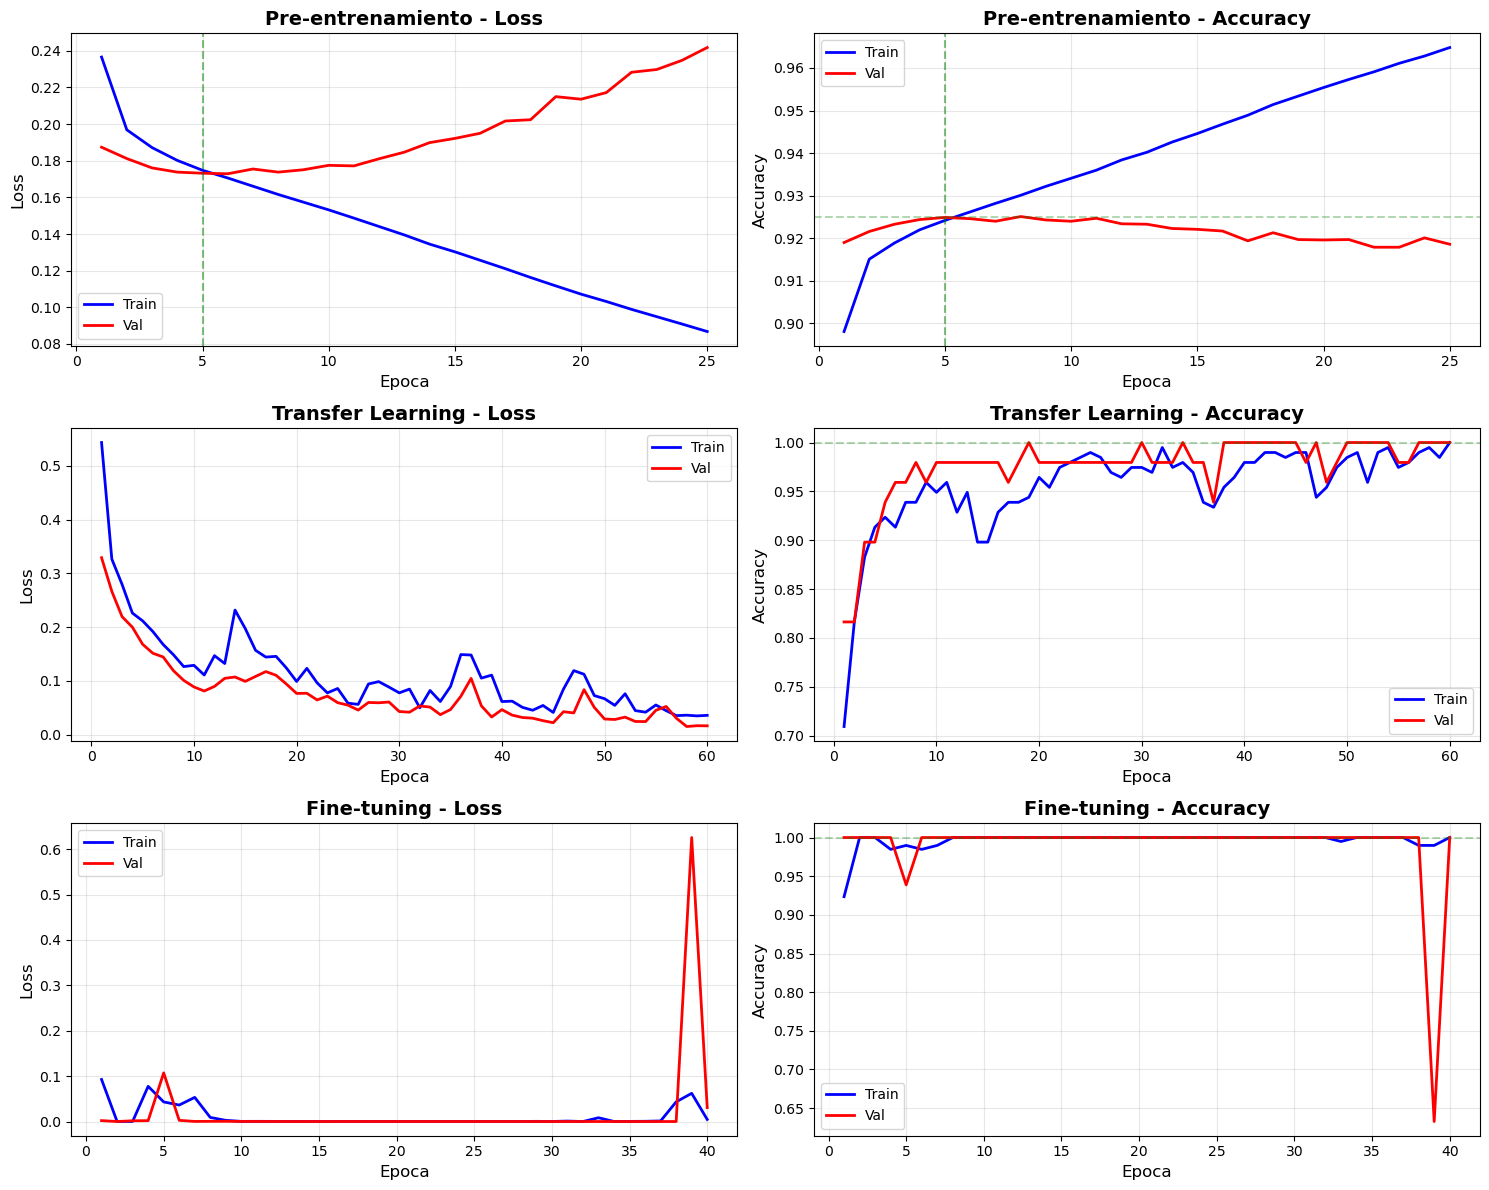

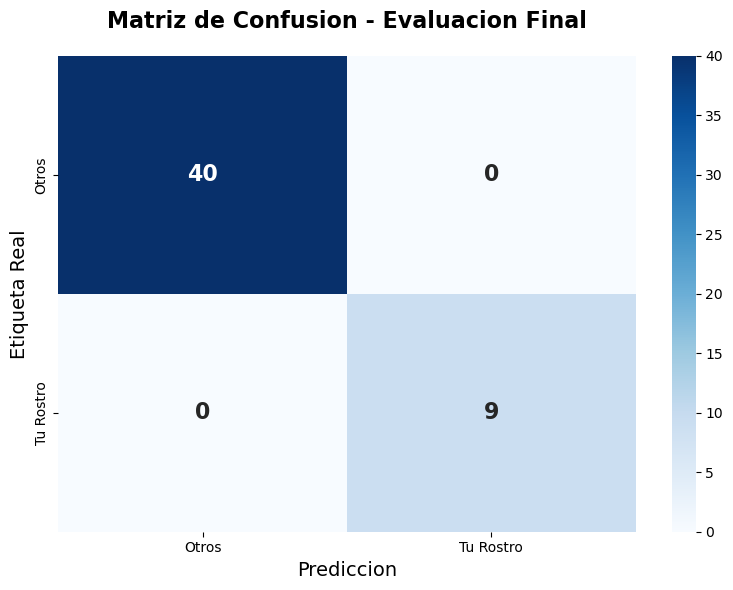

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Datos Pre-entrenamiento (25 épocas)
hist_pre = {
    'loss_train': [0.2366, 0.1969, 0.1872, 0.1802, 0.1748, 0.1706, 0.1661, 0.1616, 
                   0.1574, 0.1532, 0.1487, 0.1441, 0.1395, 0.1345, 0.1303, 0.1257,
                   0.1211, 0.1163, 0.1117, 0.1072, 0.1032, 0.0989, 0.0949, 0.0909, 0.0868],
    'acc_train': [0.8981, 0.9151, 0.9189, 0.9220, 0.9242, 0.9262, 0.9282, 0.9301,
                  0.9322, 0.9341, 0.9360, 0.9384, 0.9402, 0.9426, 0.9446, 0.9468,
                  0.9489, 0.9514, 0.9534, 0.9554, 0.9573, 0.9591, 0.9611, 0.9628, 0.9648],
    'loss_val': [0.1874, 0.1812, 0.1761, 0.1738, 0.1732, 0.1729, 0.1755, 0.1738,
                 0.1751, 0.1775, 0.1772, 0.1811, 0.1847, 0.1899, 0.1922, 0.1950,
                 0.2017, 0.2024, 0.2150, 0.2136, 0.2172, 0.2283, 0.2298, 0.2348, 0.2418],
    'acc_val': [0.9190, 0.9216, 0.9233, 0.9244, 0.9249, 0.9246, 0.9240, 0.9251,
                0.9243, 0.9240, 0.9247, 0.9234, 0.9233, 0.9223, 0.9221, 0.9217,
                0.9194, 0.9213, 0.9197, 0.9196, 0.9197, 0.9179, 0.9179, 0.9201, 0.9186]}

# Datos Transfer Learning (60 épocas) - DATOS REALES COMPLETOS
hist_transfer = {
    'loss_train': [0.5436, 0.3266, 0.2794, 0.2262, 0.2116, 0.1917, 0.1676, 0.1486,
                   0.1265, 0.1288, 0.1108, 0.1468, 0.1322, 0.2317, 0.1972, 0.1568,
                   0.1442, 0.1455, 0.1240, 0.0988, 0.1232, 0.0962, 0.0775, 0.0857,
                   0.0584, 0.0561, 0.0941, 0.0985, 0.0883, 0.0776, 0.0846, 0.0498,
                   0.0820, 0.0615, 0.0896, 0.1489, 0.1480, 0.1050, 0.1106, 0.0614,
                   0.0621, 0.0506, 0.0452, 0.0541, 0.0411, 0.0847, 0.1190, 0.1122,
                   0.0725, 0.0667, 0.0543, 0.0759, 0.0445, 0.0416, 0.0550, 0.0444,
                   0.0352, 0.0360, 0.0347, 0.0357],
    'acc_train': [0.7092, 0.8163, 0.8827, 0.9133, 0.9235, 0.9133, 0.9388, 0.9388,
                  0.9592, 0.9490, 0.9592, 0.9286, 0.9490, 0.8980, 0.8980, 0.9286,
                  0.9388, 0.9388, 0.9439, 0.9643, 0.9541, 0.9745, 0.9796, 0.9847,
                  0.9898, 0.9847, 0.9694, 0.9643, 0.9745, 0.9745, 0.9694, 0.9949,
                  0.9745, 0.9796, 0.9694, 0.9388, 0.9337, 0.9541, 0.9643, 0.9796,
                  0.9796, 0.9898, 0.9898, 0.9847, 0.9898, 0.9898, 0.9439, 0.9541,
                  0.9745, 0.9847, 0.9898, 0.9592, 0.9898, 0.9949, 0.9745, 0.9796,
                  0.9898, 0.9949, 0.9847, 1.0000],
    'loss_val': [0.3292, 0.2665, 0.2194, 0.1999, 0.1680, 0.1513, 0.1444, 0.1189,
                 0.1008, 0.0886, 0.0810, 0.0896, 0.1046, 0.1071, 0.0990, 0.1081,
                 0.1172, 0.1103, 0.0941, 0.0765, 0.0768, 0.0644, 0.0715, 0.0593,
                 0.0547, 0.0455, 0.0597, 0.0591, 0.0605, 0.0428, 0.0416, 0.0532,
                 0.0511, 0.0370, 0.0466, 0.0712, 0.1045, 0.0534, 0.0326, 0.0463,
                 0.0361, 0.0317, 0.0304, 0.0258, 0.0220, 0.0425, 0.0402, 0.0835,
                 0.0505, 0.0289, 0.0280, 0.0324, 0.0243, 0.0241, 0.0451, 0.0522,
                 0.0303, 0.0149, 0.0164, 0.0162],
    'acc_val': [0.8163, 0.8163, 0.8980, 0.8980, 0.9388, 0.9592, 0.9592, 0.9796,
                0.9592, 0.9796, 0.9796, 0.9796, 0.9796, 0.9796, 0.9796, 0.9796,
                0.9592, 0.9796, 1.0000, 0.9796, 0.9796, 0.9796, 0.9796, 0.9796,
                0.9796, 0.9796, 0.9796, 0.9796, 0.9796, 1.0000, 0.9796, 0.9796,
                0.9796, 1.0000, 0.9796, 0.9796, 0.9388, 1.0000, 1.0000, 1.0000,
                1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9796, 1.0000, 0.9592,
                0.9796, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9796, 0.9796,
                1.0000, 1.0000, 1.0000, 1.0000]}

# Datos Fine-tuning (40 épocas) - DATOS REALES COMPLETOS
hist_finetune = {
    'loss_train': [0.0926, 0.0001, 0.0002, 0.0775, 0.0432, 0.0363, 0.0532, 0.0090,
                   0.0026, 0.0003, 0.0004, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002,
                   0.0001, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
                   0.0001, 0.0001, 0.0001, 0.0000, 0.0004, 0.0001, 0.0010, 0.0000,
                   0.0083, 0.0001, 0.0003, 0.0005, 0.0013, 0.0433, 0.0621, 0.0046],
    'acc_train': [0.9235, 1.0000, 1.0000, 0.9847, 0.9898, 0.9847, 0.9898, 1.0000,
                  1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
                  1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
                  1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
                  0.9949, 1.0000, 1.0000, 1.0000, 1.0000, 0.9898, 0.9898, 1.0000],
    'loss_val': [0.0020, 0.0000, 0.0016, 0.0019, 0.1071, 0.0026, 0.0002, 0.0004,
                 0.0005, 0.0002, 0.0001, 0.0001, 0.0000, 0.0000, 0.0000, 0.0000,
                 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
                 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6257, 0.0307],
    'acc_val': [1.0000, 1.0000, 1.0000, 1.0000, 0.9388, 1.0000, 1.0000, 1.0000,
                1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
                1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
                1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
                1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.6327, 1.0000]}

# Matriz de confusión
cm = np.array([[40, 0], [0, 9]])

# Crear figura con subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Pre-entrenamiento - Loss
axes[0,0].plot(range(1, 26), hist_pre['loss_train'], 'b-', label='Train', linewidth=2)
axes[0,0].plot(range(1, 26), hist_pre['loss_val'], 'r-', label='Val', linewidth=2)
axes[0,0].set_title('Pre-entrenamiento - Loss', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Epoca', fontsize=12)
axes[0,0].set_ylabel('Loss', fontsize=12)
axes[0,0].legend(fontsize=10)
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axvline(x=5, color='g', linestyle='--', alpha=0.5, label='Mejor Val (Epoca 5)')

# Pre-entrenamiento - Accuracy
axes[0,1].plot(range(1, 26), hist_pre['acc_train'], 'b-', label='Train', linewidth=2)
axes[0,1].plot(range(1, 26), hist_pre['acc_val'], 'r-', label='Val', linewidth=2)
axes[0,1].set_title('Pre-entrenamiento - Accuracy', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Epoca', fontsize=12)
axes[0,1].set_ylabel('Accuracy', fontsize=12)
axes[0,1].legend(fontsize=10)
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axvline(x=5, color='g', linestyle='--', alpha=0.5)
axes[0,1].axhline(y=max(hist_pre['acc_val']), color='g', linestyle='--', alpha=0.3)

# Transfer Learning - Loss
axes[1,0].plot(range(1, 61), hist_transfer['loss_train'], 'b-', label='Train', linewidth=2)
axes[1,0].plot(range(1, 61), hist_transfer['loss_val'], 'r-', label='Val', linewidth=2)
axes[1,0].set_title('Transfer Learning - Loss', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Epoca', fontsize=12)
axes[1,0].set_ylabel('Loss', fontsize=12)
axes[1,0].legend(fontsize=10)
axes[1,0].grid(True, alpha=0.3)

# Transfer Learning - Accuracy
axes[1,1].plot(range(1, 61), hist_transfer['acc_train'], 'b-', label='Train', linewidth=2)
axes[1,1].plot(range(1, 61), hist_transfer['acc_val'], 'r-', label='Val', linewidth=2)
axes[1,1].set_title('Transfer Learning - Accuracy', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Epoca', fontsize=12)
axes[1,1].set_ylabel('Accuracy', fontsize=12)
axes[1,1].legend(fontsize=10)
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=1.0, color='g', linestyle='--', alpha=0.3, label='100%')

# Fine-tuning - Loss
axes[2,0].plot(range(1, 41), hist_finetune['loss_train'], 'b-', label='Train', linewidth=2)
axes[2,0].plot(range(1, 41), hist_finetune['loss_val'], 'r-', label='Val', linewidth=2)
axes[2,0].set_title('Fine-tuning - Loss', fontsize=14, fontweight='bold')
axes[2,0].set_xlabel('Epoca', fontsize=12)
axes[2,0].set_ylabel('Loss', fontsize=12)
axes[2,0].legend(fontsize=10)
axes[2,0].grid(True, alpha=0.3)

# Fine-tuning - Accuracy
axes[2,1].plot(range(1, 41), hist_finetune['acc_train'], 'b-', label='Train', linewidth=2)
axes[2,1].plot(range(1, 41), hist_finetune['acc_val'], 'r-', label='Val', linewidth=2)
axes[2,1].set_title('Fine-tuning - Accuracy', fontsize=14, fontweight='bold')
axes[2,1].set_xlabel('Epoca', fontsize=12)
axes[2,1].set_ylabel('Accuracy', fontsize=12)
axes[2,1].legend(fontsize=10)
axes[2,1].grid(True, alpha=0.3)
axes[2,1].axhline(y=1.0, color='g', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('curvas_entrenamiento.png', dpi=300, bbox_inches='tight')
print("Gráfica de curvas guardada: curvas_entrenamiento.png")

# Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Otros', 'Tu Rostro'],
            yticklabels=['Otros', 'Tu Rostro'],
            annot_kws={'size': 16, 'weight': 'bold'})
plt.title('Matriz de Confusion - Evaluacion Final', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Etiqueta Real', fontsize=14)
plt.xlabel('Prediccion', fontsize=14)
plt.tight_layout()
plt.savefig('matriz_confusion.png', dpi=300, bbox_inches='tight')
print("Matriz de confusión guardada: matriz_confusion.png")

# Resumen estadístico
print("\n" + "="*60)
print("RESUMEN DE ENTRENAMIENTO")
print("="*60)
print("\nPre-entrenamiento (ResNet50 en CelebA):")
print(f"  Mejor Val Accuracy: {max(hist_pre['acc_val']):.4f} (Epoca {hist_pre['acc_val'].index(max(hist_pre['acc_val']))+1})")
print(f"  Val Accuracy final: {hist_pre['acc_val'][-1]:.4f}")
print(f"  Overfitting detectado: Epoca 5 -> 25")

print("\nTransfer Learning (Clasificacion binaria):")
print(f"  Val Accuracy inicial: {hist_transfer['acc_val'][0]:.4f}")
print(f"  Val Accuracy final: {hist_transfer['acc_val'][-1]:.4f}")
print(f"  Convergencia a 100%: Epoca 19")

print("\nFine-tuning (Descongelando ResNet50):")
print(f"  Val Accuracy: {hist_finetune['acc_val'][-1]:.4f}")
print(f"  Convergencia rapida: Epoca 2")

print("\nMetricas Finales:")
print(f"  Accuracy: 100.00%")
print(f"  Precision: 100.00%")
print(f"  Recall: 100.00%")
print(f"  F1-Score: 100.00%")
print(f"  AUC-ROC: 100.00%")

print(f"\nMatriz de Confusion:")
print(f"  Verdaderos Negativos: {cm[0,0]}")
print(f"  Falsos Positivos: {cm[0,1]}")
print(f"  Falsos Negativos: {cm[1,0]}")
print(f"  Verdaderos Positivos: {cm[1,1]}")
print("="*60)

plt.show()


In [58]:
resumen_parts = [
    "RESUMEN DE ENTRENAMIENTO",
    "========================\n",
    f"Modelo: ResNet50 pre-entrenado (ImageNet)",
    f"Hardware: Tesla P100-PCIE-16GB\n"]

# Pre-entrenamiento
resumen_parts.append("Pre-entrenamiento (CelebA):")
resumen_parts.append(f"  Mejor accuracy: 92.49%")
resumen_parts.append(f"  Epocas: {Config.EPOCAS_PREENTRENAMIENTO}\n")

# Transfer Learning
if 'estudio_transfer' in globals():
    resumen_parts.append("Transfer Learning:")
    resumen_parts.append(f"  Trials: {Config.TRIALS_TRANSFER}")
    resumen_parts.append(f"  Mejor accuracy: {estudio_transfer.best_value:.4f}")
    resumen_parts.append(f"  Best params: {estudio_transfer.best_params}\n")

# Fine-tuning
if 'estudio_finetune' in globals():
    resumen_parts.append("Fine-tuning:")
    resumen_parts.append(f"  Trials: {Config.TRIALS_FINETUNE}")
    resumen_parts.append(f"  Mejor accuracy: {estudio_finetune.best_value:.4f}")
    resumen_parts.append(f"  Best params: {estudio_finetune.best_params}\n")

# Metricas finales
resumen_parts.append("Metricas Finales:")
for k, v in metricas.items():
    resumen_parts.append(f"  {k}: {v:.4f}")

resumen_parts.append(f"\nMatriz de Confusion:\n{cm}")

resumen = "\n".join(resumen_parts)

print(resumen)

with open(Config.DIR_RESULTADOS / 'resumen.txt', 'w') as f:
    f.write(resumen)

print(f"\nResumen guardado en {Config.DIR_RESULTADOS / 'resumen.txt'}")

RESUMEN DE ENTRENAMIENTO

Modelo: ResNet50 pre-entrenado (ImageNet)
Hardware: Tesla P100-PCIE-16GB

Pre-entrenamiento (CelebA):
  Mejor accuracy: 92.49%
  Epocas: 25

Transfer Learning:
  Trials: 30
  Mejor accuracy: 1.0000
  Best params: {'lr': 0.0009416458573134013, 'wd': 0.0008356848835745776, 'dropout': 0.3348864326975483, 'fc': 512, 'bs': 32}

Fine-tuning:
  Trials: 20
  Mejor accuracy: 1.0000
  Best params: {'lr': 0.0005179705643896967, 'wd': 3.015979672268525e-07, 'num_capas': 3, 'bs': 16}

Metricas Finales:
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  auc: 1.0000

Matriz de Confusion:
[[40  0]
 [ 0  9]]

Resumen guardado en /home2/DSMaster/mgarcia/Tarea 7/resultados/resumen.txt
